**Imports & Configuration**

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

In [27]:
# ── Style global ────
plt.rcParams.update({
    'figure.facecolor' : '#0f0f1a',
    'axes.facecolor'   : '#1a1a2e',
    'axes.edgecolor'   : '#444',
    'axes.labelcolor'  : 'white',
    'xtick.color'      : 'white',
    'ytick.color'      : 'white',
    'text.color'       : 'white',
    'grid.color'       : '#333',
    'grid.linestyle'   : '--',
    'grid.alpha'       : 0.5,
})

PALETTE = ['#00d4ff','#ff6b6b','#ffd93d','#6bcb77',
           '#c77dff','#ff9f43','#48dbfb','#ff6b81',
           '#a29bfe','#55efc4']

# ── Chemins ───────
BASE_DIR  = Path("/home/admin1/Documents/SN CNN_DEEP_LEARNING")
IMG_DIR   = BASE_DIR / "dataset/images/images"
LABEL_DIR = BASE_DIR / "dataset/label/label"
RESULTS   = BASE_DIR / "results"
RESULTS.mkdir(exist_ok=True)

# ── Paramètres ─────
IMG_SIZE    = 224
BATCH_SIZE  = 32
NUM_WORKERS = 2

In [28]:
# ── SOURCE UNIQUE DE VÉRITÉ — Classes ──────────────────────
CLASSES = sorted([
    "crease", "crescent_gap", "inclusion", "oil_spot",
    "punching_hole", "rolled_pit", "silk_spot",
    "waist folding", "water_spot", "welding_line"
])
CLASS2IDX   = {cls: idx for idx, cls in enumerate(CLASSES)}
NUM_CLASSES = len(CLASSES)

print("✅ Imports OK")
print(f"🖼️  Image size   : {IMG_SIZE}x{IMG_SIZE}")
print(f"📦 Batch size   : {BATCH_SIZE}")
print(f"🔧 PyTorch      : {torch.__version__}")
print(f"📌 NUM_CLASSES  : {NUM_CLASSES}")
print(f"\n✅ Classes chargées :")
for i, cls in enumerate(CLASSES):
    print(f"   [{i}] {cls}")

✅ Imports OK
🖼️  Image size   : 224x224
📦 Batch size   : 32
🔧 PyTorch      : 2.10.0+cu128
📌 NUM_CLASSES  : 10

✅ Classes chargées :
   [0] crease
   [1] crescent_gap
   [2] inclusion
   [3] oil_spot
   [4] punching_hole
   [5] rolled_pit
   [6] silk_spot
   [7] waist folding
   [8] water_spot
   [9] welding_line


**Calcul Mean/Std**

In [ ]:
def compute_mean_std(img_dir, img_size=224, max_samples=500):
    """
    Calcule mean/std réels du dataset
    ⚠️ Cherche dans les sous-dossiers de classes
    """
    img_dir = Path(img_dir)

    # ✅ Cherche dans les sous-dossiers (pas à la racine)
    img_paths = []
    for class_dir in img_dir.iterdir():
        if class_dir.is_dir():
            img_paths += list(class_dir.glob("*.jpg"))
            img_paths += list(class_dir.glob("*.png"))
            img_paths += list(class_dir.glob("*.bmp"))

    print(f"🔎 Images trouvées pour calcul : {len(img_paths)}")

    # Limite pour la rapidité
    if len(img_paths) > max_samples:
        np.random.seed(42)
        img_paths = list(
            np.random.choice(img_paths, max_samples, replace=False)
        )
    transform = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor()
    ])

    mean  = torch.zeros(3)
    std   = torch.zeros(3)
    count = 0

    print(f"📊 Calcul sur {len(img_paths)} images...")
    for path in img_paths:
        try:
            img    = Image.open(path).convert("RGB")
            tensor = transform(img)       # [3, H, W]
            mean  += tensor.mean(dim=[1, 2])
            std   += tensor.std(dim=[1, 2])
            count += 1
        except Exception:
            continue

    mean /= count
    std  /= count

    return mean.tolist(), std.tolist()

# ── Lancement ──────
MEAN, STD = compute_mean_std(IMG_DIR)

print("\n╔══════════════════════════════════════════╗")
print("║     NORMALISATION DU DATASET             ║")
print("╠══════════════════════════════════════════╣")
print(f"║  Mean : R={MEAN[0]:.4f}  G={MEAN[1]:.4f}  B={MEAN[2]:.4f}     ║")
print(f"║  Std  : R={STD[0]:.4f}  G={STD[1]:.4f}  B={STD[2]:.4f}     ║")
print("╠══════════════════════════════════════════╣")
print("║  ImageNet : mean=0.485/0.456/0.406       ║")
print("╚══════════════════════════════════════════╝")

🔎 Images trouvées pour calcul : 2306
📊 Calcul sur 500 images...

╔══════════════════════════════════════════╗
║     NORMALISATION DU DATASET             ║
╠══════════════════════════════════════════╣
║  Mean : R=0.3310  G=0.3310  B=0.3310     ║
║  Std  : R=0.0964  G=0.0964  B=0.0964     ║
╠══════════════════════════════════════════╣
║  ImageNet : mean=0.485/0.456/0.406       ║
╚══════════════════════════════════════════╝


**SteelDefectDataset**

In [34]:
# ============================================================
#  STEELDEFECTDATASET — Scan sous-dossiers de classes
# ============================================================

class SteelDefectDataset(Dataset):
    """
    Lit les images depuis :
    IMG_DIR/
    ├── crease/     *.jpg
    ├── oil_spot/   *.jpg
    └── ...
    """

    def __init__(self, img_dir, transform=None):
        self.img_dir   = Path(img_dir)
        self.transform = transform
        self.samples   = []   # [(Path, int), ...]
        self.labels    = []   # [int, ...]
        self._scan()

    def _scan(self):
        missing = []
        for cls_name in CLASSES:
            cls_dir = self.img_dir / cls_name
            if not cls_dir.exists():
                missing.append(cls_name)
                continue

            cls_idx = CLASS2IDX[cls_name]
            images  = (
                list(cls_dir.glob("*.jpg"))  +
                list(cls_dir.glob("*.jpeg")) +
                list(cls_dir.glob("*.png"))  +
                list(cls_dir.glob("*.bmp"))
            )
            for p in sorted(images):
                self.samples.append((p, cls_idx))
                self.labels.append(cls_idx)

        if missing:
            print(f"⚠️  Dossiers absents : {missing}")

        # Rapport distribution
        cnt = Counter(self.labels)
        print(f"\n{'Classe':<22} {'Idx':>3} {'N':>6}  {'Distribution':}")
        print("─" * 55)
        for cls_name in CLASSES:
            idx = CLASS2IDX[cls_name]
            n   = cnt.get(idx, 0)
            bar = "█" * (n // 20)
            print(f"  {cls_name:<20} {idx:>3} {n:>6}  {bar}")
        print("─" * 55)
        print(f"  {'TOTAL':<20} {'':>3} {len(self.samples):>6}\n")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label


# ── Test rapide ────────────────────────────────────────────
raw_dataset = SteelDefectDataset(IMG_DIR)
print(f"✅ Dataset : {len(raw_dataset)} images | {NUM_CLASSES} classes")

# Vérification d'un sample
img, lbl = raw_dataset[0]
print(f"🔎 Sample[0] → shape={img.shape} | "
      f"label={lbl} ({CLASSES[lbl]})")


Classe                 Idx      N  Distribution
───────────────────────────────────────────────────────
  crease                 0     52  ██
  crescent_gap           1    226  ███████████
  inclusion              2    216  ██████████
  oil_spot               3    204  ██████████
  punching_hole          4    219  ██████████
  rolled_pit             5     31  █
  silk_spot              6    650  ████████████████████████████████
  waist folding          7    146  ███████
  water_spot             8    289  ██████████████
  welding_line           9    273  █████████████
───────────────────────────────────────────────────────
  TOTAL                      2306

✅ Dataset : 2306 images | 10 classes
🔎 Sample[0] → shape=(1000, 2048, 3) | label=0 (crease)


**Pipelines Augmentation**

In [ ]:
# ===========================
#  PIPELINES ALBUMENTATIONS
# ===========================
train_transform = A.Compose([
    # Géométrie
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.1,
        rotate_limit=15,  p=0.4
    ),
    # Photométrie
    A.RandomBrightnessContrast(
        brightness_limit=0.2, contrast_limit=0.2, p=0.5
    ),
    A.GaussNoise(var_limit=(10, 50), p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    # Régularisation spatiale
    A.CoarseDropout(
        max_holes=8, max_height=16,
        max_width=16, fill_value=0, p=0.3
    ),
    # Normalisation avec les stats du dataset
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

# ── Résumé ─────
print("✅ Pipeline TRAIN :")
for t in train_transform.transforms:
    print(f"   → {t.__class__.__name__}")

print("\n✅ Pipeline VAL :")
for t in val_transform.transforms:
    print(f"   → {t.__class__.__name__}")


✅ Pipeline TRAIN :
   → Resize
   → HorizontalFlip
   → VerticalFlip
   → RandomRotate90
   → ShiftScaleRotate
   → RandomBrightnessContrast
   → GaussNoise
   → GaussianBlur
   → CoarseDropout
   → Normalize
   → ToTensorV2

✅ Pipeline VAL :
   → Resize
   → Normalize
   → ToTensorV2


**Split + WeightedSampler + DataLoaders**

In [37]:
# ── Split 80/20 stratifié ──────────────────────────────────
all_indices = list(range(len(raw_dataset)))
all_labels  = raw_dataset.labels

train_idx, val_idx = train_test_split(
    all_indices,
    test_size    = 0.2,
    stratify     = all_labels,
    random_state = 42
)

# ── TransformSubset ────────────────────────────────────────
class TransformSubset(Dataset):
    """Applique un transform différent selon train/val"""

    def __init__(self, dataset, indices, transform):
        self.dataset   = dataset
        self.indices   = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[self.indices[idx]]
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

    @property
    def labels(self):
        return [self.dataset.labels[i] for i in self.indices]

train_dataset = TransformSubset(raw_dataset, train_idx, train_transform)
val_dataset   = TransformSubset(raw_dataset, val_idx,   val_transform)

# ── WeightedRandomSampler ──────────────────────────────────
def make_weighted_sampler(dataset):
    """Rééquilibre les classes par sur/sous-échantillonnage"""
    labels       = dataset.labels
    class_count  = Counter(labels)
    class_weight = {cls: 1.0 / cnt for cls, cnt in class_count.items()}
    sample_w     = torch.FloatTensor(
                       [class_weight[l] for l in labels])

    sampler = WeightedRandomSampler(
        weights     = sample_w,
        num_samples = len(sample_w),
        replacement = True
    )

    # Rapport
    print("╔══════════════════════════════════════════════════╗")
    print("║         WEIGHTED RANDOM SAMPLER                  ║")
    print("╠══════════════════════════════════════════════════╣")
    print(f"║  {'Classe':<22} {'N':>5}  {'Poids':>8}  Bar      ║")
    print("╠══════════════════════════════════════════════════╣")
    for cls_idx in sorted(class_count.keys()):
        n      = class_count[cls_idx]
        w      = class_weight[cls_idx]
        bar    = "█" * int(w * 5000)
        name   = CLASSES[cls_idx]
        print(f"║  {name:<22} {n:>5}  {w:.5f}  {bar:<8} ║")
    print("╚══════════════════════════════════════════════════╝")

    return sampler

train_sampler = make_weighted_sampler(train_dataset)

# ── DataLoaders ────────────────────────────────────────────
train_loader = DataLoader(
    train_dataset,
    batch_size  = BATCH_SIZE,
    sampler     = train_sampler,   # remplace shuffle=True
    num_workers = NUM_WORKERS,
    pin_memory  = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    num_workers = NUM_WORKERS,
    pin_memory  = True
)

# ── Résumé ─────────────────────────────────────────────────
print(f"\n{'═'*50}")
print(f"  📦 Train  : {len(train_dataset):>5} images "
      f"| {len(train_loader):>3} batches")
print(f"  📦 Val    : {len(val_dataset):>5} images "
      f"| {len(val_loader):>3} batches")
print(f"  ✅ Sampler rééquilibré actif")
print(f"{'═'*50}")


╔══════════════════════════════════════════════════╗
║         WEIGHTED RANDOM SAMPLER                  ║
╠══════════════════════════════════════════════════╣
║  Classe                     N     Poids  Bar      ║
╠══════════════════════════════════════════════════╣
║  crease                    41  0.02439  █████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ ║
║  crescent_gap             181  0.00552  ███████████████████████████ ║
║  inclusion                173  0.00578  ████████████████████████████ ║
║  oil_spot                 163  0.00613  ██████████████████████████████ ║
║  punching_hole            175  0.00571  ████████████████████████████ ║
║  rolled_pit                25  0.04000  ████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ ║
║  silk_spot                52

**Visualisation Augmentation**

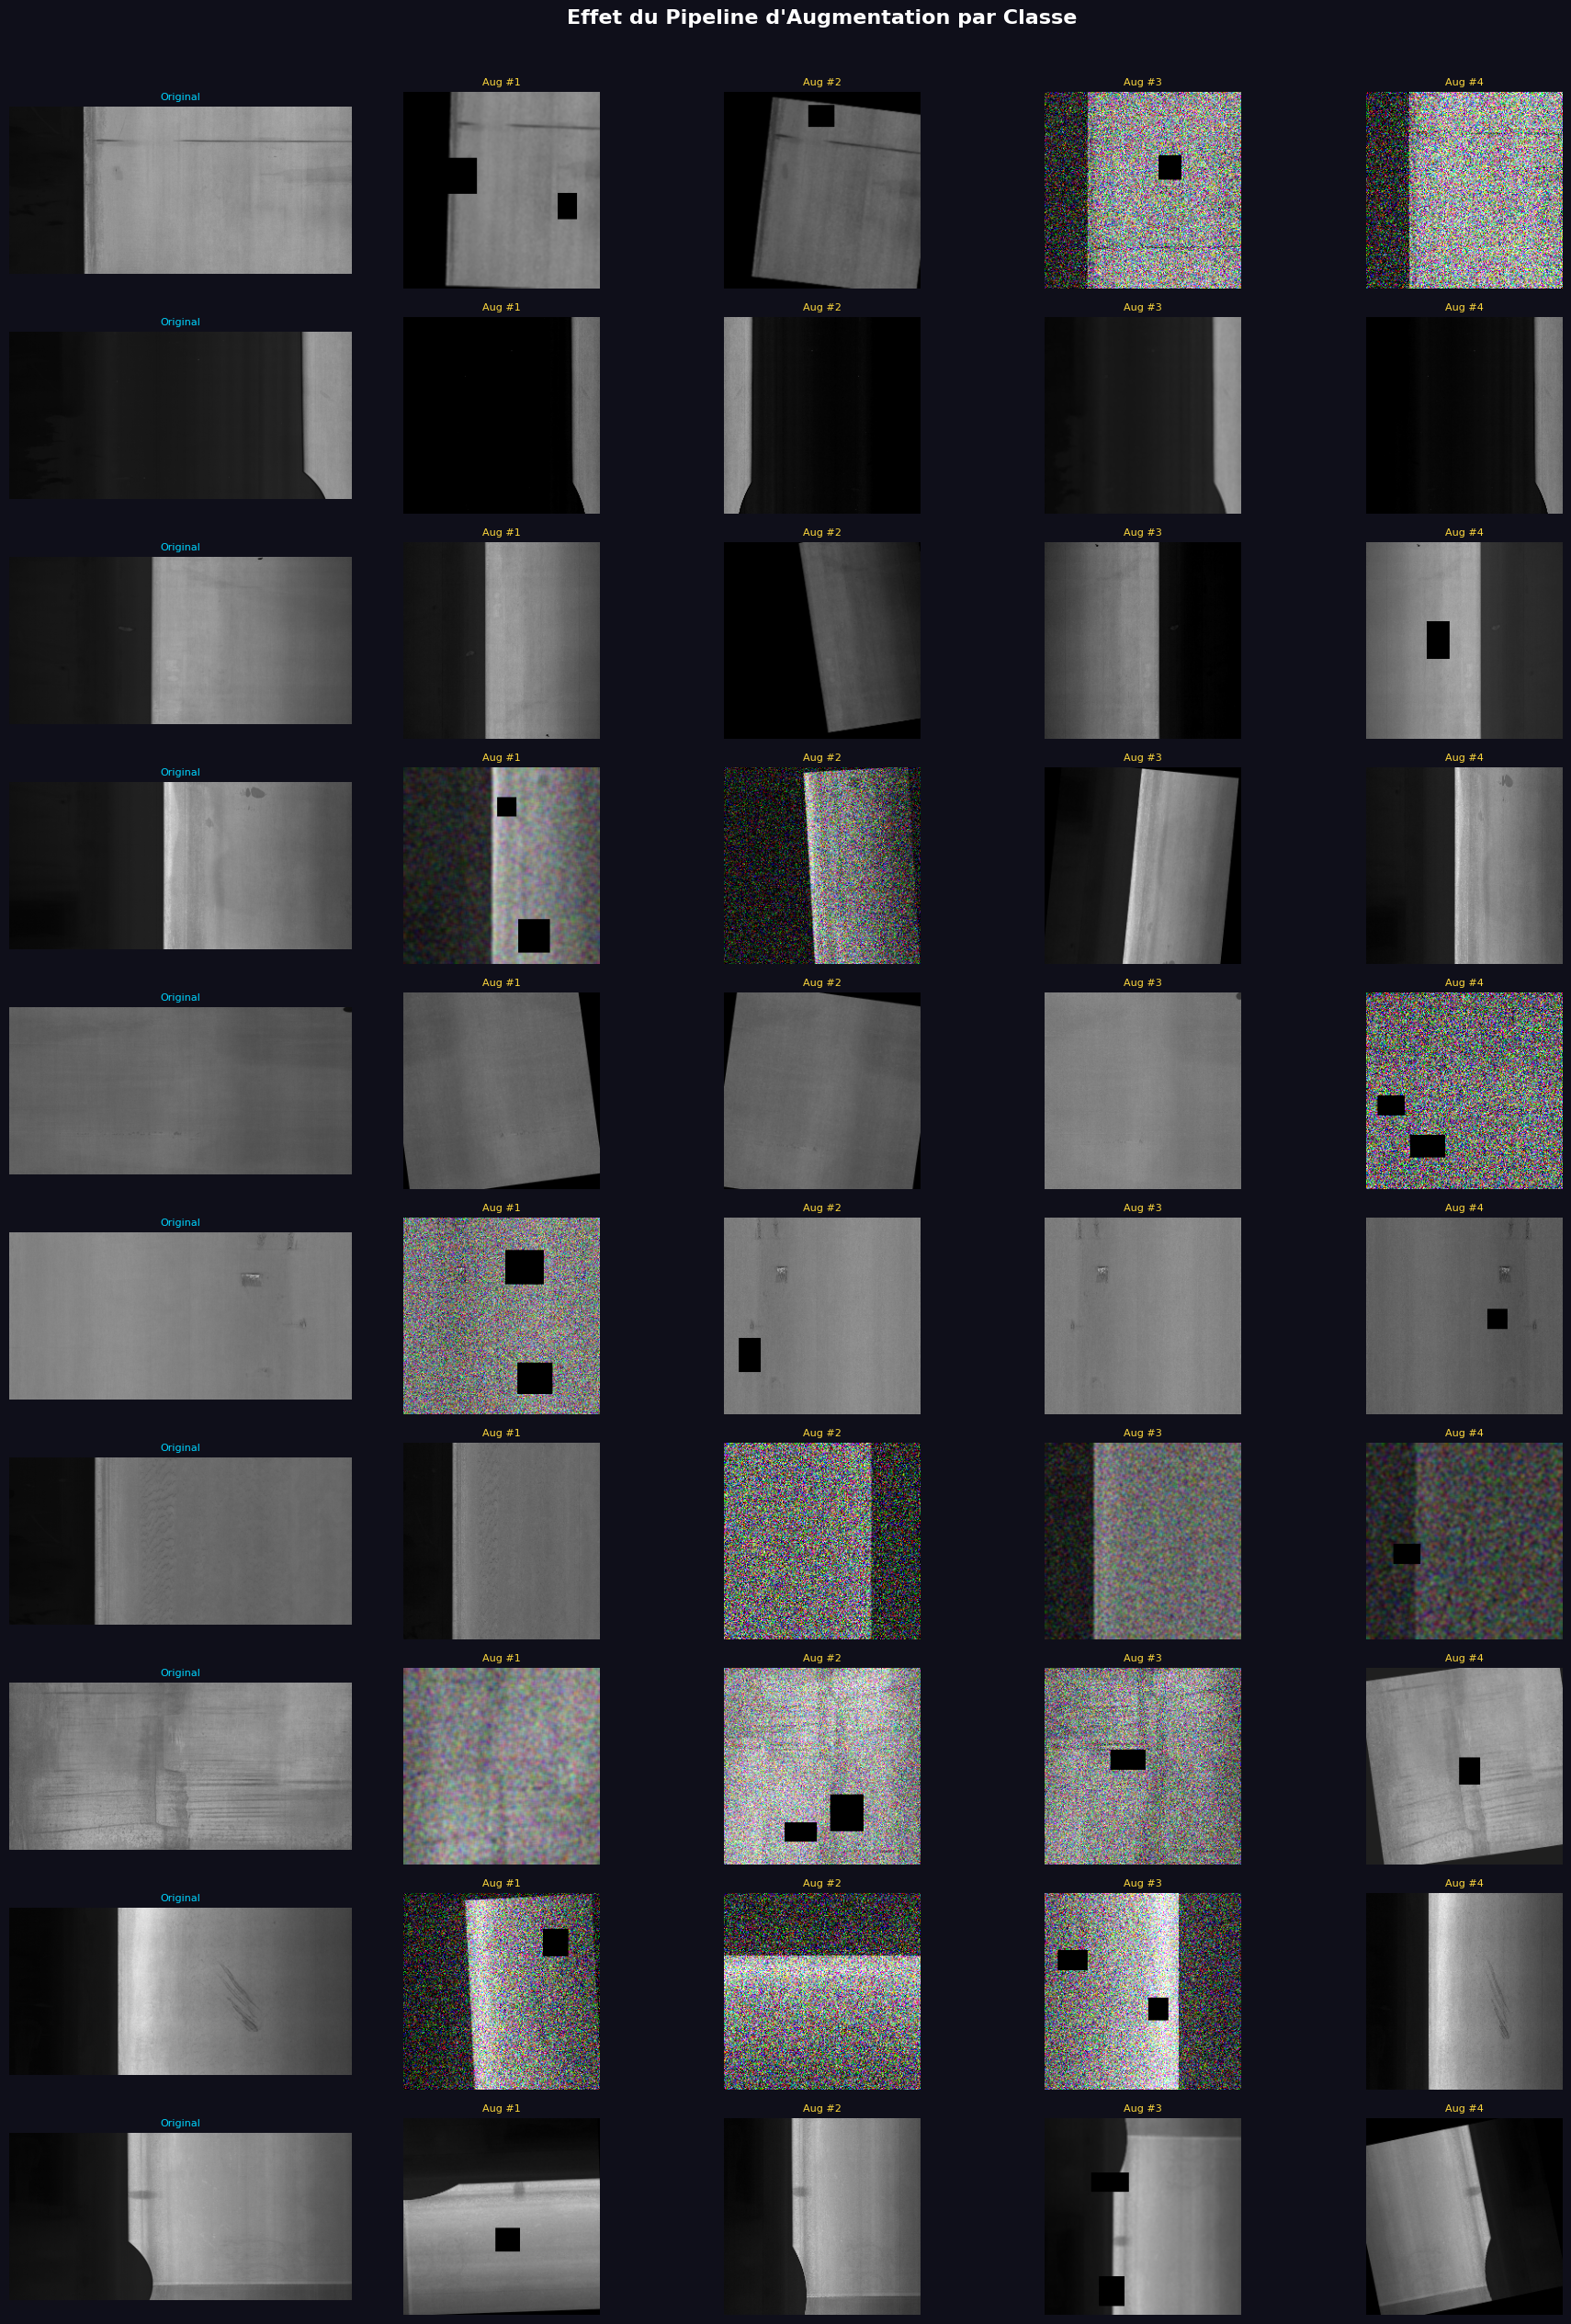

✅ Sauvegardé → results/augmentation_preview.png


In [38]:
def denormalize(tensor, mean, std):
    """Reconstruit l'image visible depuis un tensor normalisé"""
    t = tensor.clone().permute(1, 2, 0).numpy()
    t = t * np.array(std) + np.array(mean)
    return np.clip(t, 0, 1)

# Choisit 1 image par classe pour la démo
class_samples = {}
for img_path, label in raw_dataset.samples:
    if label not in class_samples:
        class_samples[label] = img_path
    if len(class_samples) == NUM_CLASSES:
        break

# ── Figure : original vs 4 augmentations ──────────────────
n_aug = 4
fig, axes = plt.subplots(
    NUM_CLASSES, n_aug + 1,
    figsize=(18, NUM_CLASSES * 2.5)
)
fig.suptitle("Effet du Pipeline d'Augmentation par Classe",
             fontsize=16, fontweight='bold', color='white', y=1.01)

for row, (cls_idx, img_path) in enumerate(
        sorted(class_samples.items())):

    raw_img = np.array(Image.open(img_path).convert("RGB"))

    # Colonne 0 — Image originale
    axes[row, 0].imshow(raw_img)
    axes[row, 0].set_title("Original", fontsize=8, color='#00d4ff')
    axes[row, 0].set_ylabel(CLASSES[cls_idx],
                             fontsize=9, color=PALETTE[cls_idx],
                             rotation=0, labelpad=80, va='center')
    axes[row, 0].axis('off')

    # Colonnes 1..n_aug — Versions augmentées
    for col in range(1, n_aug + 1):
        aug    = train_transform(image=raw_img)
        tensor = aug["image"]
        vis    = denormalize(tensor, MEAN, STD)

        axes[row, col].imshow(vis)
        axes[row, col].set_title(f"Aug #{col}",
                                  fontsize=8, color='#ffd93d')
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(RESULTS / "augmentation_preview.png",
            dpi=150, bbox_inches='tight',
            facecolor='#0f0f1a')
plt.show()
print("✅ Sauvegardé → results/augmentation_preview.png")


**Validation du Batch**

╔══════════════════════════════════════════╗
║        VALIDATION BATCH                  ║
╠══════════════════════════════════════════╣
║Batch shape: torch.Size([32, 3, 224, 224])║
║dtype         : torch.float32             ║
║Min / Max   : -3.434 / 6.941              ║
║Labels uniq   : 10 classes dans ce batch  ║
╠══════════════════════════════════════════╣
║  crease               :  3  ███          ║
║  crescent_gap         :  2  ██           ║
║  inclusion            :  2  ██           ║
║  oil_spot             :  3  ███          ║
║  punching_hole        :  7  ███████      ║
║  rolled_pit           :  4  ████         ║
║  silk_spot            :  3  ███          ║
║  waist folding        :  1  █            ║
║  water_spot           :  5  █████        ║
║  welding_line         :  2  ██           ║
╚══════════════════════════════════════════╝


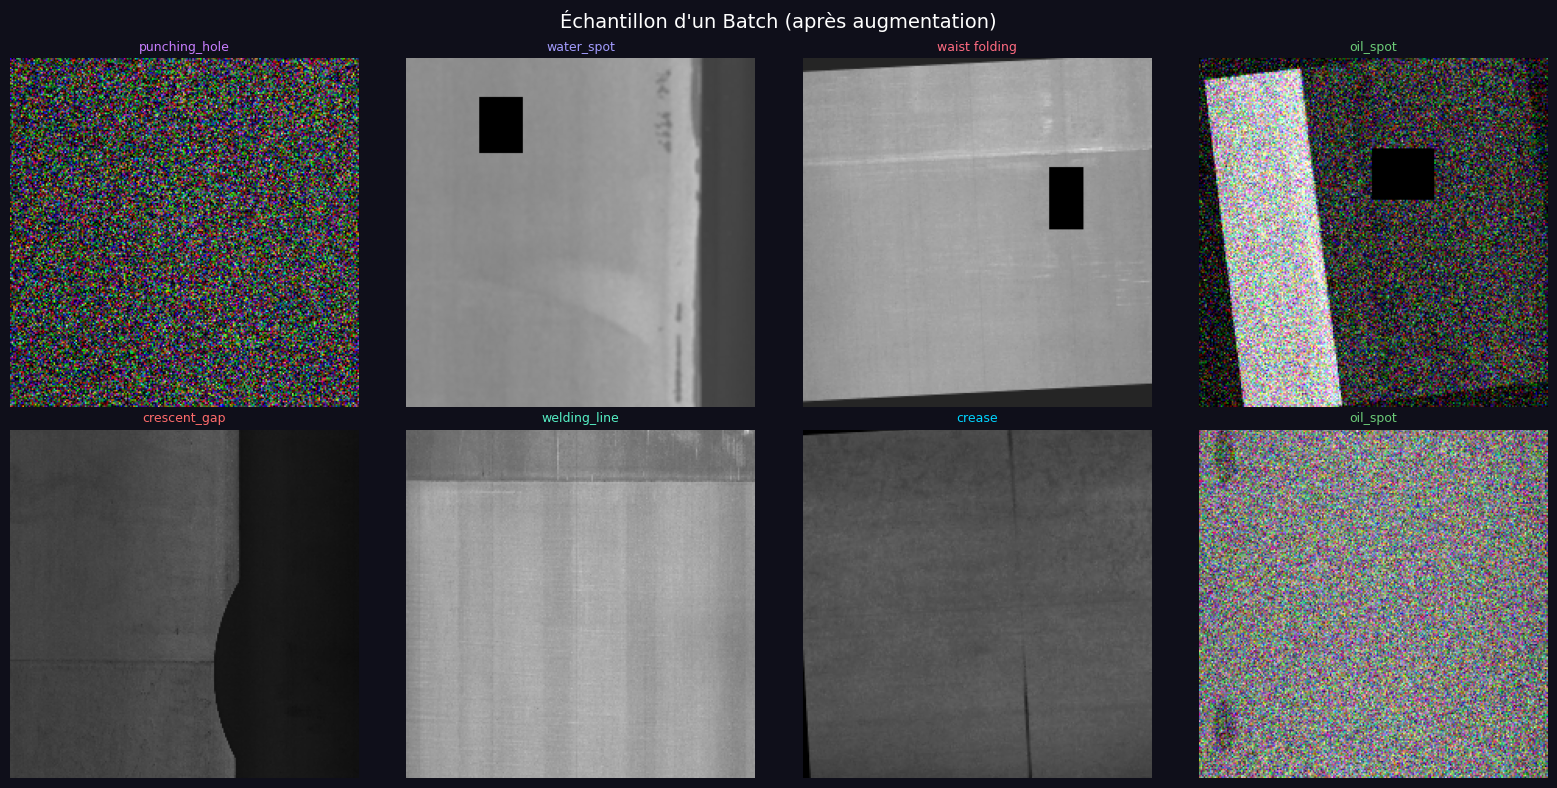

✅ Sauvegardé → results/batch_sample.png


In [47]:
# Récupère 1 batch train
images_batch, labels_batch = next(iter(train_loader))

print("╔══════════════════════════════════════════╗")
print("║        VALIDATION BATCH                  ║")
print("╠══════════════════════════════════════════╣")
print(f"║Batch shape: {str(images_batch.shape):<26}║")
print(f"║dtype         : {str(images_batch.dtype):<26}║")
print(f"║Min / Max   : {images_batch.min():.3f} / "
      f"{images_batch.max():.3f}              ║")
print(f"║Labels uniq   : {len(labels_batch.unique())} classes dans ce batch  ║")
print("╠══════════════════════════════════════════╣")

# Distribution des labels dans ce batch
cnt_batch = Counter(labels_batch.tolist())
for cls_idx, n in sorted(cnt_batch.items()):
    bar = "█" * n
    print(f"║  {CLASSES[cls_idx]:<20} : {n:>2}  {bar:<12} ║")
print("╚══════════════════════════════════════════╝")

# ── Visualisation de 8 images du batch ───────────────────
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Échantillon d'un Batch (après augmentation)",
             fontsize=14, color='white')

for i, ax in enumerate(axes.flat):
    vis = denormalize(images_batch[i], MEAN, STD)
    ax.imshow(vis)
    ax.set_title(CLASSES[labels_batch[i].item()],
                 fontsize=9, color=PALETTE[labels_batch[i].item()])
    ax.axis('off')

plt.tight_layout()
plt.savefig(RESULTS / "batch_sample.png",
            dpi=150, bbox_inches='tight',
            facecolor='#0f0f1a')
plt.show()
print("✅ Sauvegardé → results/batch_sample.png")


**Export des objets pour le Notebook 03**

In [51]:
# =========================================
#  EXPORT — Sauvegarde pour le Notebook 03
# =========================================
import pickle

export = {
    "CLASSES"        : CLASSES,
    "CLASS2IDX"      : CLASS2IDX,
    "NUM_CLASSES"    : NUM_CLASSES,
    "MEAN"           : MEAN,
    "STD"            : STD,
    "IMG_SIZE"       : IMG_SIZE,
    "BATCH_SIZE"     : BATCH_SIZE,
    "NUM_WORKERS"    : NUM_WORKERS,
    "train_loader"   : train_loader,
    "val_loader"     : val_loader,
    "train_dataset"  : train_dataset,
    "val_dataset"    : val_dataset,
}

save_path = BASE_DIR / "results/preprocessing_config.pkl"
with open(save_path, "wb") as f:
    pickle.dump(export, f)

print("╔══════════════════════════════════════════╗")
print("║      ✅ NOTEBOOK 02 TERMINÉ              ║")
print("╠══════════════════════════════════════════╣")
print(f"║  Train loader  : {len(train_loader):>4} batches            ║")
print(f"║  Val loader    : {len(val_loader):>4} batches            ║")
print(f"║  Mean          : {[round(m,3) for m in MEAN]}   ║")
print(f"║  Std           : {[round(s,3) for s in STD]}   ║")
print("╠══════════════════════════════════════════╣")
print("║  → Prêt pour Notebook 03 : CNN Build     ║")
print("╚══════════════════════════════════════════╝")


╔══════════════════════════════════════════╗
║      ✅ NOTEBOOK 02 TERMINÉ              ║
╠══════════════════════════════════════════╣
║  Train loader  :   58 batches            ║
║  Val loader    :   15 batches            ║
║  Mean          : [0.331, 0.331, 0.331]   ║
║  Std           : [0.096, 0.096, 0.096]   ║
╠══════════════════════════════════════════╣
║  → Prêt pour Notebook 03 : CNN Build     ║
╚══════════════════════════════════════════╝
